In [243]:
%matplotlib inline
import cv2
import os
import csv
import sys
import time
# import logging
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [256]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [246]:
PATH = 'data/95010232_q/'
IMAGE_DIR = "./out_7"
SHAPE = (360, 640)
AREA_COLOR = (66, 183, 42)
AREA_PTS = np.array([[260, 90], [300, 90], [380, 350], [130, 350], [235,150]]) 
labels = np.genfromtxt("data/labels.csv")

In [247]:
# Display one image
def display_one(a, title1, path, frame_number=0, save=False):
    fig = plt.figure()
    plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    if (save):
        fig.savefig(IMAGE_DIR + (path % frame_number), dpi=500)
    
# Display two images
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()
    
def displayH(base_frame, processed, title1, title2, path, frame_number=0,save=False):
    fig = plt.figure()
#     fig.suptitle("Capacity: {}%".format(capacity*100), fontsize=16)
    plt.subplot(211),plt.imshow(base_frame),plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(212),plt.imshow(processed),plt.title(title2)
    plt.xticks([]), plt.yticks([])
    
    if (save):
        fig.savefig(IMAGE_DIR + (path % frame_number), dpi=500)

In [248]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [258]:
def train_bg_subtractor(inst, cap, num=50):
    '''
    BG substractor need process some amount of frames to start giving result
    '''
#     i = 0 
    for frame in cap:
        inst.apply(frame, None, 0.01)
#         i += 1
#         if i >= num:
#             return cap 
    return cap

In [250]:
''' Apply bgsubtractor to get foreground img '''
class GenerateForeground(object):
    def __init__(self, bg_subtractor):
        self.bg_subtractor = bg_subtractor
    
    def __call__(self,context):
        frame = context['frame'].copy()
        frame_number = context['frame_number']
        
        #blur original frame 
        frame = cv2.GaussianBlur(frame, (5,5), 0)
#         median_blur = cv2.medianBlur(result, 10)
#         bilateral_blur = cv2.bilateralFilter(result, 10, 75, 75)
        fg = self.bg_subtractor.apply(frame, None, 0.01)
        
        # just thresholding values
        fg[fg < 240] = 0 
        context['fg'] = fg    #fg segmentation 
        
        print("Frame #{} processed.".format(frame_number))
        return context
        

In [251]:
''' Filter_mask '''
class FilterImage(object):        
    def __call__(self,context):
        fg = context['fg'].copy()
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))

        # Fill any small holes
        closing = cv2.morphologyEx(fg, cv2.MORPH_CLOSE, kernel)
        
        # Remove noise
        opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

        # Dilate to merge adjacent blobs
#         dilation = cv2.dilate(opening, kernel, iterations=2)
        
        context['filtered'] = opening
        
        return context

In [252]:
'''masking'''
class ApplyMask():
    def __init__(self, area_mask):
        self.area_mask = area_mask
    
    def __call__(self,context):
        base_frame = context['frame'].copy()
        frame = context['filtered'].copy()
        mask = cv2.bitwise_and(frame,frame,mask = self.area_mask)  # filtered + masked frame
        
        img = np.zeros(base_frame.shape, base_frame.dtype)
        img[:, :] = AREA_COLOR
        mask_origin = cv2.bitwise_and(img, img, mask=self.area_mask)
        cv2.addWeighted(mask_origin, 1, base_frame, 1, 0, base_frame)   # masked origin frame 
        
        context['mask'] = mask
        context['mask_origin'] = base_frame
        return context

In [195]:
class CalculateScore(): 
    def __init__(self, area_mask):
        self.area_mask = area_mask
        
    def __call__(self,context):
        frame = context['mask'].copy()
        total_area = np.count_nonzero(self.area_mask)
        white = np.count_nonzero(frame)  #count foreground pixels 
        capacity = white/total_area * 100
        context['capacity'] = capacity
        return context

In [253]:
class PipelineRunner(object):
    def __init__(self, pipeline=None):
        self.pipeline = pipeline or []
        self.context = {}
        
    def set_context(self, data):
        self.context = data 
    
    def run(self):
        for p in self.pipeline:
            self.context = p(self.context)
        return self.context 

In [254]:
''' PCA '''
def applyPCA(train,test,n):
    pca = PCA(n_components= n, svd_solver='auto', whiten=True, random_state=42)
    pca.fit(train)  #(n_samples, n_components)
    new_train = pca.transform(train)
    new_test = pca.transform(test)
    return new_train, new_test

In [241]:
'''Evaluation using logistic regression'''
def Logistic(X_train, X_test, y_train, y_test):
    log = LogisticRegression(solver='liblinear',multi_class='auto')
    log.fit(X_train, y_train)
    
    train_pred = log.predict(X_train)
    test_pred = log.predict(X_test)
    
#     print("Train accuracy", sum(train_pred == y_train )/len(y_train))
#     print("Test accuracy", sum(test_pred == y_test )/len(y_test))

    Ein = log.score(X_train,y_train)
    Eout = log.score(X_test,y_test)
        
#     print("Train accuracy", Ein)
#     print("Test accuracy", Eout)
    
    return (Ein, Eout, test_pred) 

In [255]:
'''SVM'''
def SVM(X_train, X_test, y_train, y_test):
    svc = SVC(kernel='linear', class_weight='balanced', gamma='auto', C=100)
    svc.fit(X_train,y_train)
        
#     train_pred = svc.predict(X_train)
#     test_pred = svc.predict(X_test)
    
#     print("Train accuracy", sum(train_pred == y_train )/len(y_train))
#     print("Test accuracy", sum(test_pred == y_test )/len(y_test))
        
    Ein = svc.score(X_train,y_train)
    Eout = svc.score(X_test,y_test)
        
    print("Train accuracy", Ein)
    print("Test accuracy", Eout)
    return (Ein, Eout) 

In [269]:
results = []  #capacity 
frames = []   #filtered
masking = []  #masked filtered img
processed = []   #2d img to 1d 
ori= []  #masked original img
def main():
     
    #load frames from PATH 
    cap = load_images_from_folder(PATH) 
    
    #vary number of train image for training bg subtractor 
    for i in np.linspace(0.1,)
    
    #split image into train, test 
    img_train, img_test, cls_train, cls_test = train_test_split(cap, labels, test_size=0.5, random_state=101)
    
    # creting MOG bg subtractor with 500 frames in cache and shadow detction
    bg_subtractor = cv2.createBackgroundSubtractorMOG2(history=20, detectShadows=True)
    
    #train bg subtractor 
    train_bg_subtractor(bg_subtractor,img_train)
    print("bg subtractor !")
    
    #get bg image 
#     bg_image = bg_subtractor.getBackgroundImage()
#     plt.imshow(bg_image)
    
    #create pipeline processor
    generateForeground = GenerateForeground(bg_subtractor=bg_subtractor)
    
    #create mask
    base = np.zeros(SHAPE + (3,), dtype='uint8')
    area_mask = cv2.fillPoly(base, [AREA_PTS], (255, 255, 255))[:, :, 0]
    applyMask = ApplyMask(area_mask=area_mask) 
    
    #setup pipeline for processing image 
    pipeline = PipelineRunner(pipeline=[
        generateForeground,
        FilterImage(),
    ])
    
    #pick every 4th image to speed up process 
    frame_number = -1
    for i in range(0,len(cap)):
        frame = cap[i]
        ori.append(frame)
        if not frame.any():
            print("Frame capture failed, stopping...")
            break
            
        frame_number += 1
        pipeline.set_context({
            'frame': frame,
            'frame_number': frame_number
        }) 
        
        context = pipeline.run()
#         displayH(frame, context['filtered'],"/ex3_%s.png", frame_number, save=False)
#         results.append(context['capacity'])
#         frames.append(context['filtered'])
        processed.append(context['filtered'].reshape(-1))
#         masking.append(context['mask'])
#         ori_mask.append(context['mask_origin'])

In [270]:
if __name__ == "__main__":
    if not os.path.exists(IMAGE_DIR):
        print("Creating image directory: ", IMAGE_DIR)
        os.makedirs(IMAGE_DIR)
main()

bg subtractor !
Frame #0 processed.
Frame #1 processed.
Frame #2 processed.
Frame #3 processed.
Frame #4 processed.
Frame #5 processed.
Frame #6 processed.
Frame #7 processed.
Frame #8 processed.
Frame #9 processed.
Frame #10 processed.
Frame #11 processed.
Frame #12 processed.
Frame #13 processed.
Frame #14 processed.
Frame #15 processed.
Frame #16 processed.
Frame #17 processed.
Frame #18 processed.
Frame #19 processed.
Frame #20 processed.
Frame #21 processed.
Frame #22 processed.
Frame #23 processed.
Frame #24 processed.
Frame #25 processed.
Frame #26 processed.
Frame #27 processed.
Frame #28 processed.
Frame #29 processed.
Frame #30 processed.
Frame #31 processed.
Frame #32 processed.
Frame #33 processed.
Frame #34 processed.
Frame #35 processed.
Frame #36 processed.
Frame #37 processed.
Frame #38 processed.
Frame #39 processed.
Frame #40 processed.
Frame #41 processed.
Frame #42 processed.
Frame #43 processed.
Frame #44 processed.
Frame #45 processed.
Frame #46 processed.
Frame #

In [271]:
X_train, X_test, y_train, y_test = train_test_split(processed, labels, test_size=0.33, random_state=101)

In [272]:
'''Evaluation using Logistic Regression on raw processed data '''
Ein, Eout, pred = Logistic(X_train, X_test, y_train, y_test)
print(Ein)
print(Eout)

1.0
1.0


In [273]:
'''PCA and Logistic Regrssion (150 components)'''
new_train, new_test = applyPCA(X_train, X_test,80)
Ein, Eout, pred = Logistic(new_train, new_test, y_train, y_test)
print(Ein)
print(Eout)

0.9864864864864865
1.0


In [51]:
'''PCA and SVM (150 components)'''
# new_frames = applyPCA(np.asarray(processed),80)
Ein, Eout = SVM(new_train, new_test, y_train, y_test)

Train accuracy 1.0
Test accuracy 0.9594594594594594


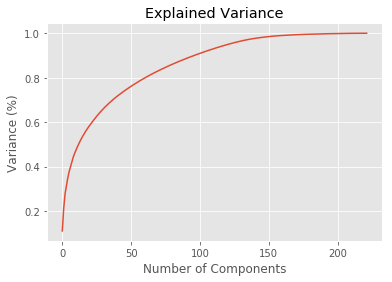

In [94]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

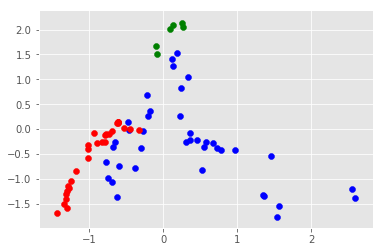

In [25]:
xx = new_test[:,0]
yy = new_test[:,1]
colors= ['red', 'green', 'blue']
for i,label in enumerate(y_test):
    x = xx[i]
    y = yy[i]
    c = colors[int(label)]
    plt.scatter(x, y,color=c)
plt.show()

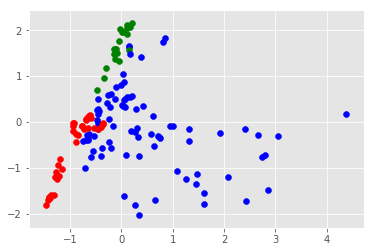

In [26]:
xx = new_train[:,0]
yy = new_train[:,1]
colors= ['red', 'green', 'blue']
for i,label in enumerate(y_train):
    x = xx[i]
    y = yy[i]
    c = colors[int(label)]
    plt.scatter(x, y,color=c)
plt.show()

In [90]:
err_in = []
err_out = []
krange = [1,2,3,4] + list(range(6,100,2))
for i in krange:
    new_train, new_test = applyPCA(X_train, X_test,i)
    Ein, Eout = Logistic(new_train, new_test, y_train, y_test)
    err_in.append(Ein)
    err_out.append(Eout)

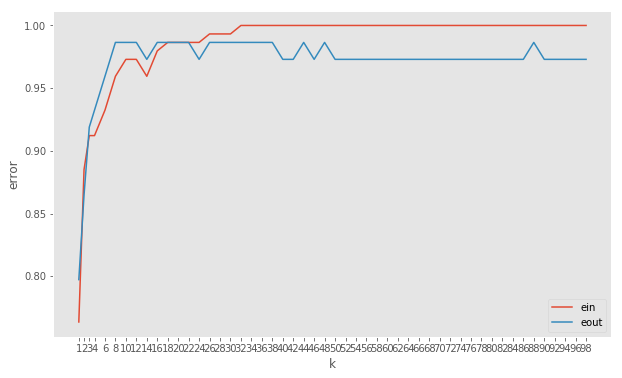

In [173]:
fig = plt.figure(figsize=(10,6))
ax = fig.gca()
ax.plot(krange,err_in,label="ein")
ax.plot(krange,err_out,label="eout")
ax.set_xticks(krange)
ax.set_xlabel('k')
ax.set_ylabel('error')
ax.grid()
plt.legend()

train 0.9662162162162162
test 0.9864864864864865


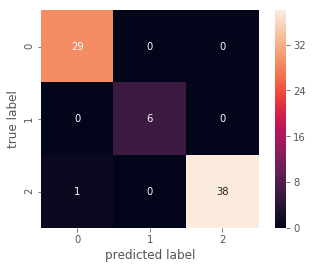

In [169]:
from sklearn.metrics import confusion_matrix
pca_train, pca_test = applyPCA(X_train, X_test,15)
Ein, Eout, test_pred = Logistic(pca_train, pca_test, y_train, y_test)
print("train", Ein)
print("test", Eout)
mat = confusion_matrix(test_pred, y_test)
sns.heatmap(mat.T, square=True, annot=True, fmt='d')
plt.xlabel('predicted label')
plt.ylabel('true label');

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


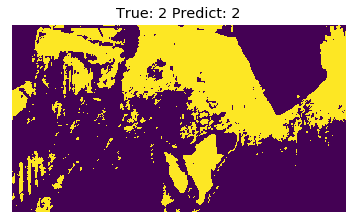

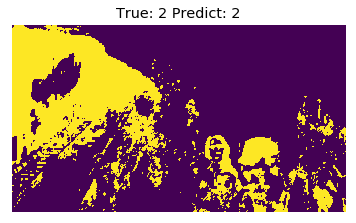

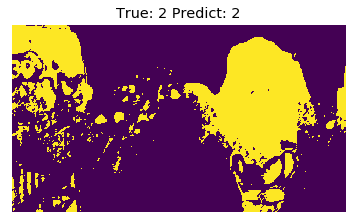

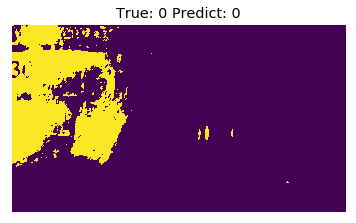

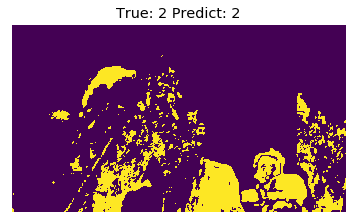

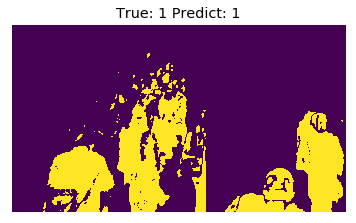

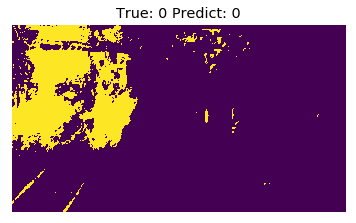

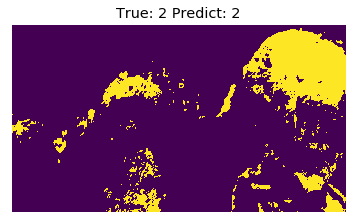

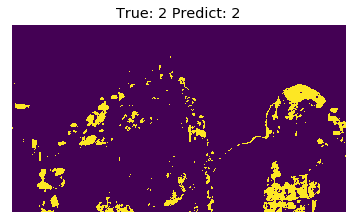

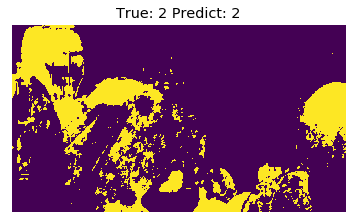

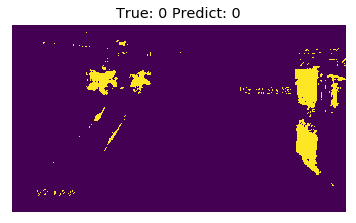

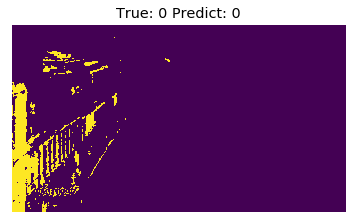

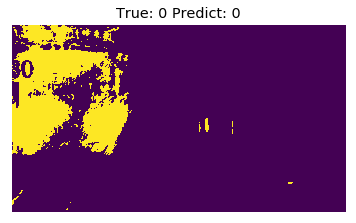

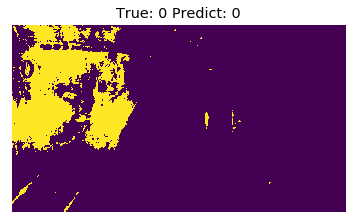

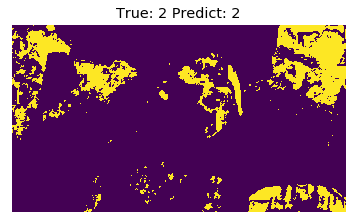

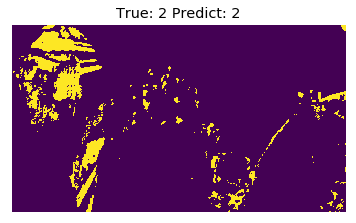

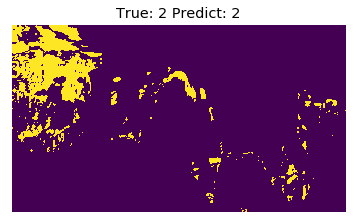

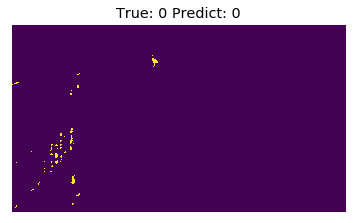

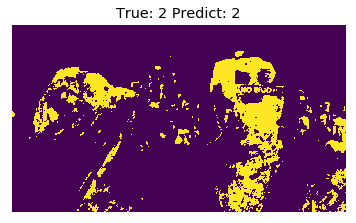

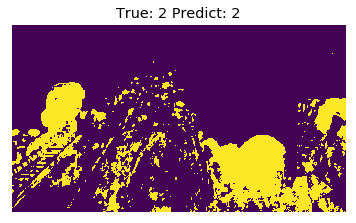

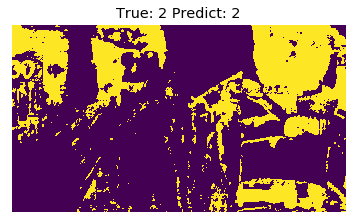

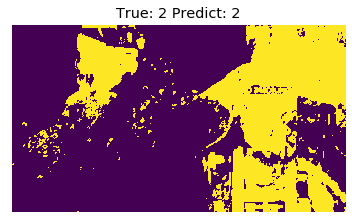

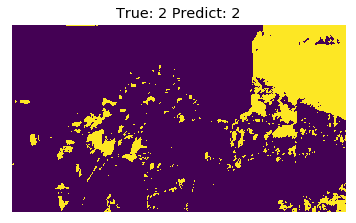

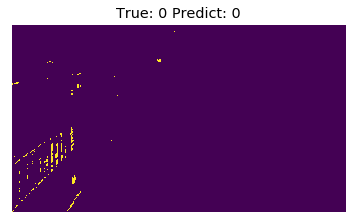

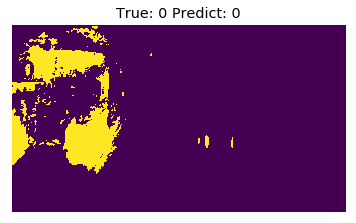

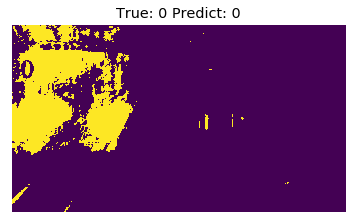

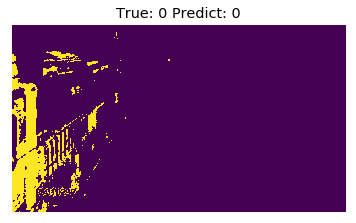

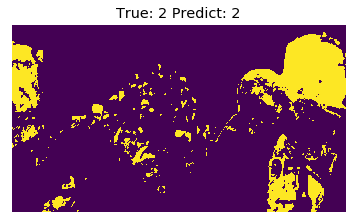

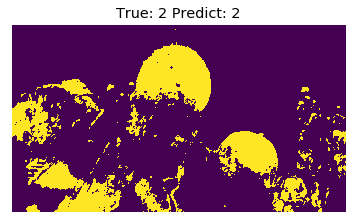

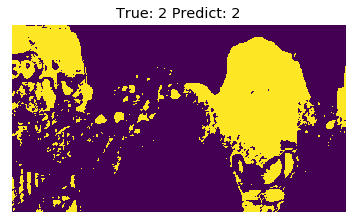

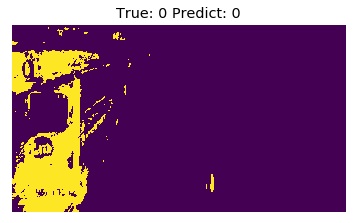

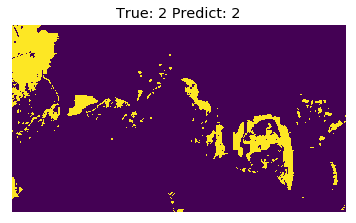

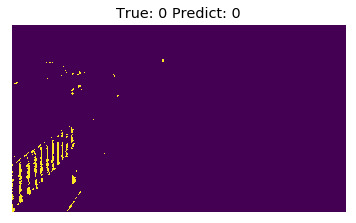

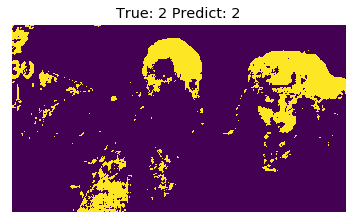

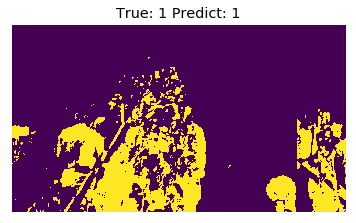

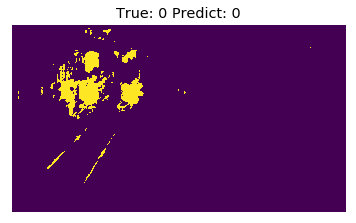

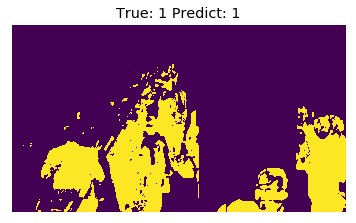

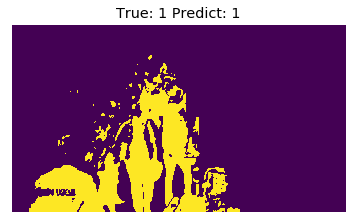

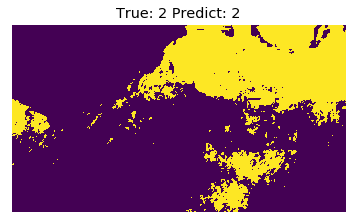

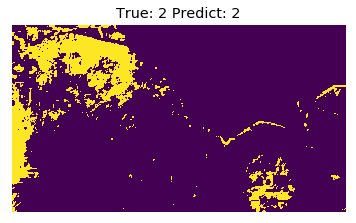

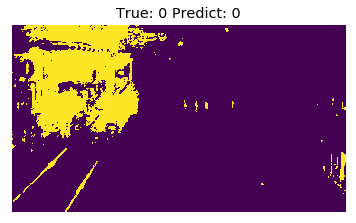

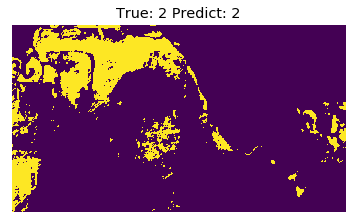

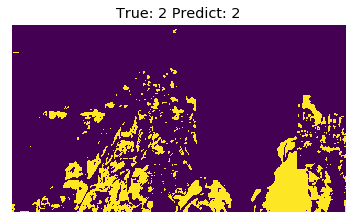

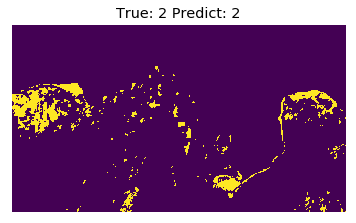

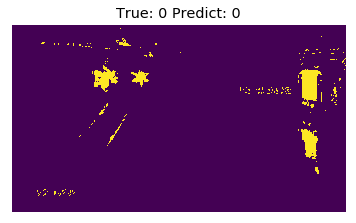

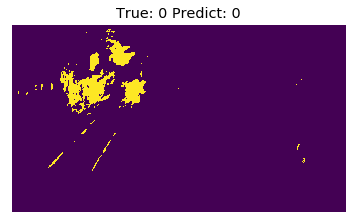

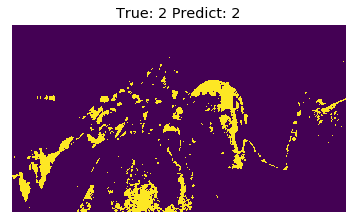

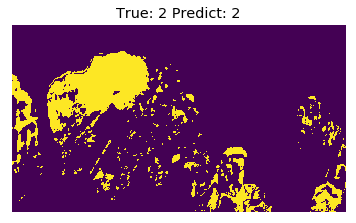

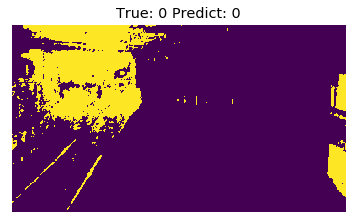

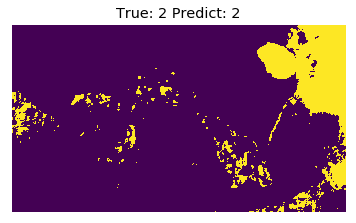

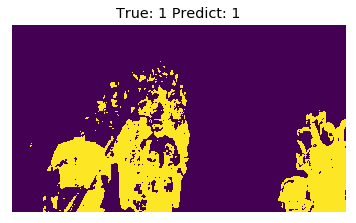

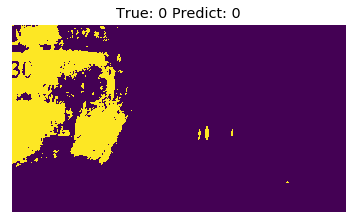

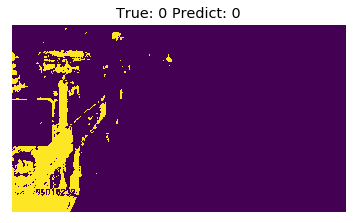

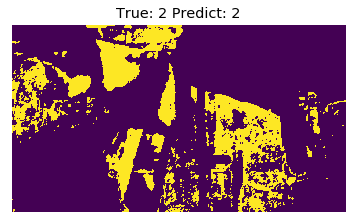

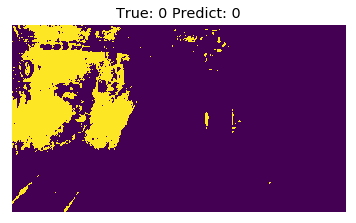

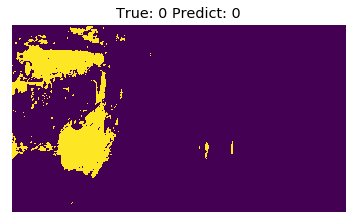

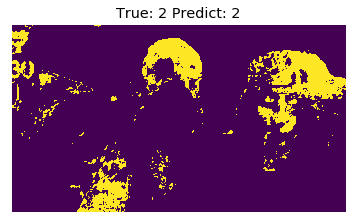

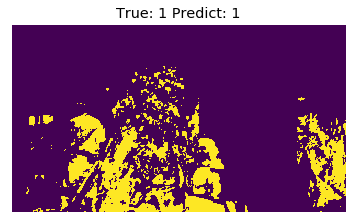

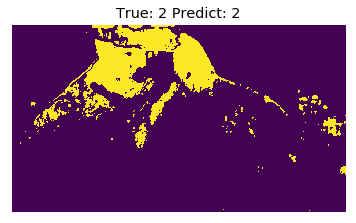

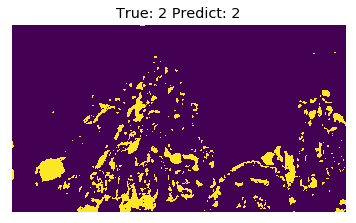

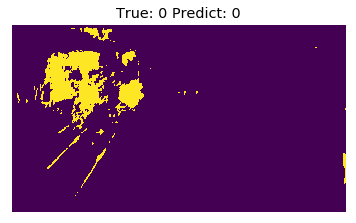

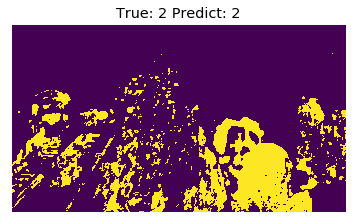

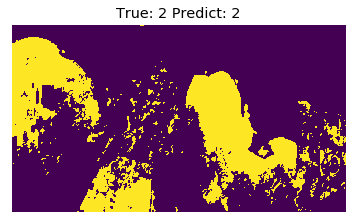

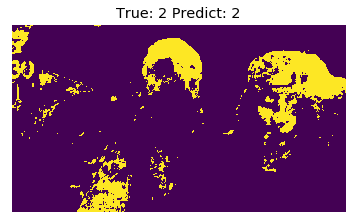

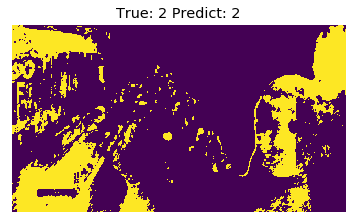

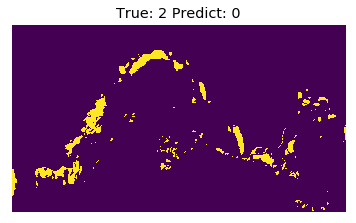

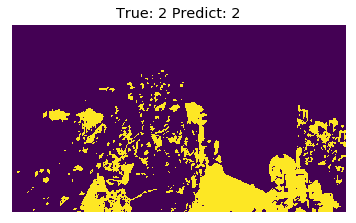

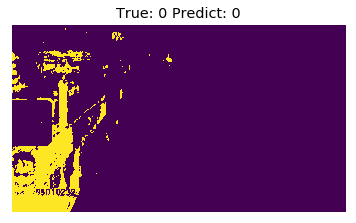

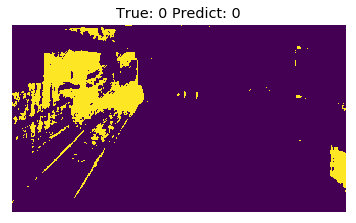

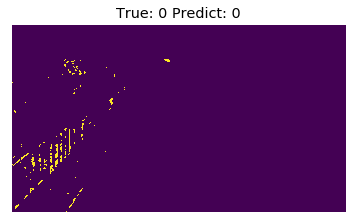

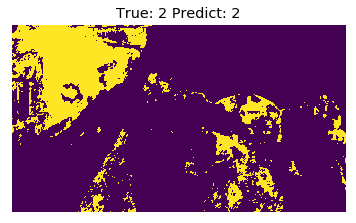

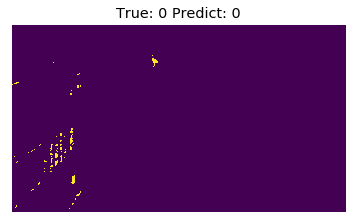

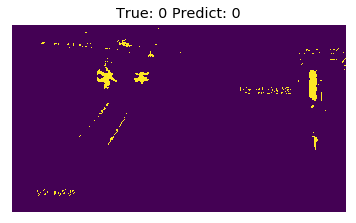

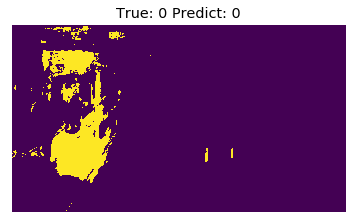

In [171]:
for i in range(len(X_test)):
    frame = X_test[i].reshape(SHAPE)
    title = "True: " + str(int(y_test[i])) + " " + "Predict: " + str(int(test_pred[i]))
    display_one(frame, title1 = title, path="/ex5_%s.png", frame_number=i, save=True)

In [227]:
#ShuffleSplit, logistic  
processed_data = np.asarray(processed)
from sklearn.model_selection import ShuffleSplit
scores = []
stest_indexs = []
ss = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
for train_index, test_index in ss.split(processed):
    X_train, y_train = processed_data[train_index], labels[train_index]
    X_test, y_test = processed_data[test_index], labels[test_index]
    Ein, Eout, pred = Logistic(X_train, X_test, y_train, y_test)
    stest_indexs.append(test_index)
    scores.append(Eout)
print("mean score:", np.mean(scores))
print("std score:", np.std(scores))
print("scores",scores)

mean score: 0.9696428571428571
std score: 0.0299340260968575
scores [0.9821428571428571, 1.0, 0.8928571428571429, 0.9464285714285714, 0.9821428571428571, 0.9821428571428571, 0.9642857142857143, 0.9821428571428571, 1.0, 0.9642857142857143]


In [281]:
# stest_indexs

In [225]:
#KFold, shuffle false  
processed_data = np.asarray(processed)
from sklearn.model_selection import KFold
preds = []
k_scores = []
test_indexs = []
kf = KFold(n_splits=5, shuffle=False)
for train_index, test_index in kf.split(processed):
    X_train, y_train = processed_data[train_index], labels[train_index]
    X_test, y_test = processed_data[test_index], labels[test_index]
    Ein, Eout, pred = Logistic(X_train, X_test, y_train, y_test)
    test_indexs.append(test_index)
    k_scores.append(Eout)
    preds.append(pred)
print("mean score:", np.mean(k_scores))
print("std score:", np.std(k_scores))
print("scores",k_scores)

mean score: 0.5853535353535354
std score: 0.3896877535290077
scores [0.08888888888888889, 0.13333333333333333, 0.8636363636363636, 0.9772727272727273, 0.8636363636363636]


In [282]:
# test_indexs

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


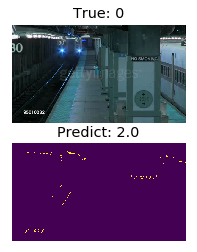

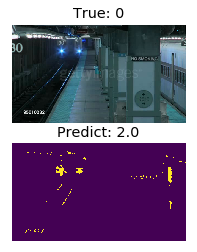

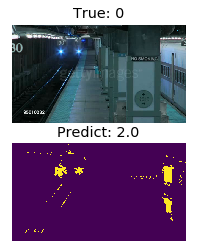

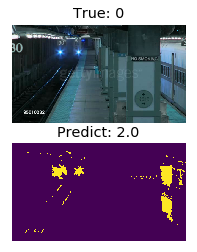

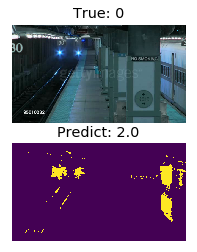

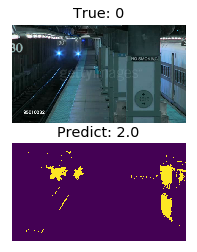

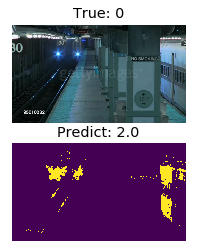

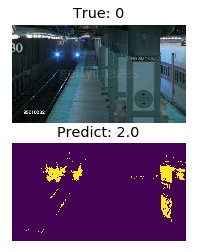

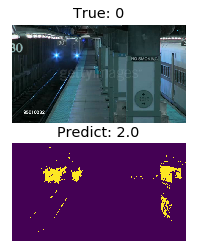

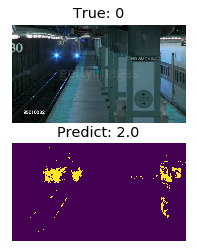

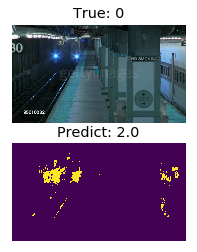

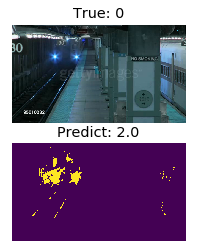

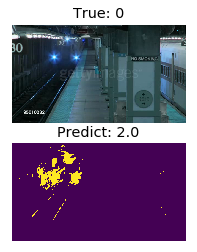

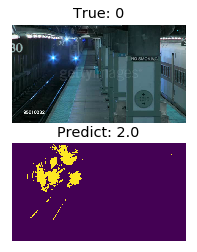

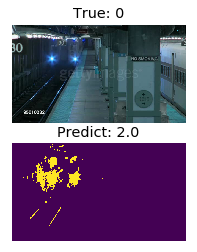

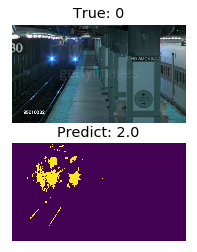

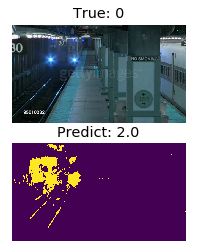

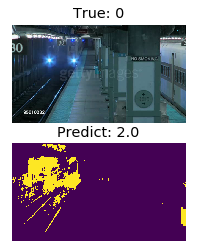

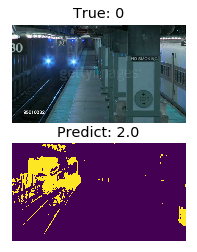

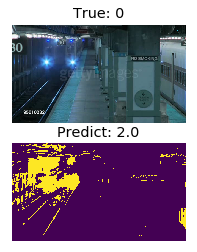

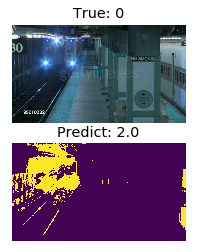

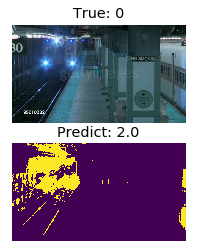

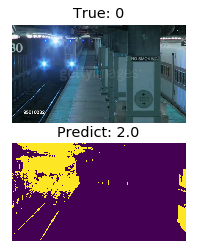

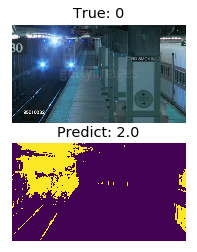

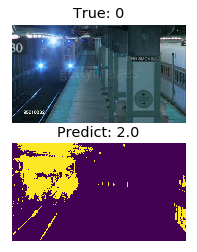

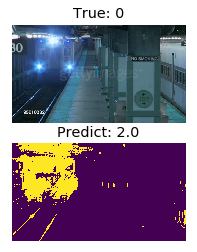

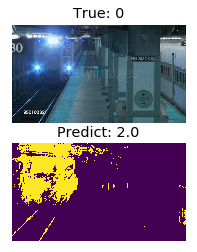

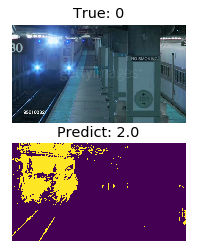

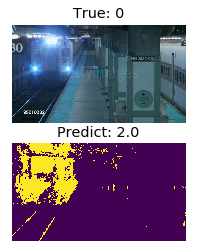

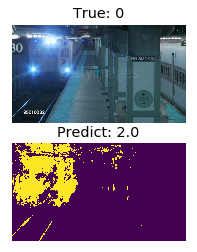

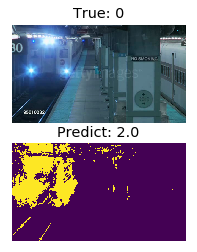

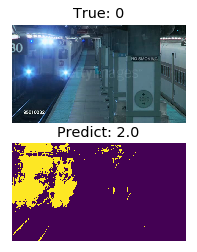

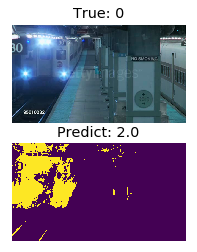

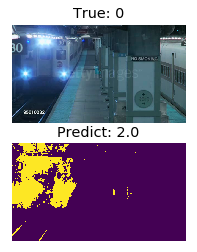

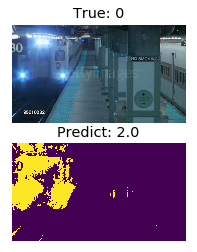

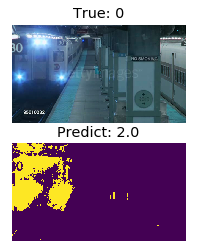

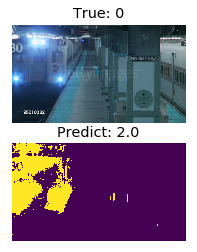

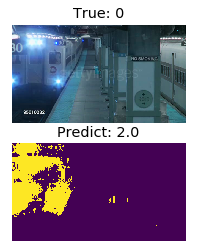

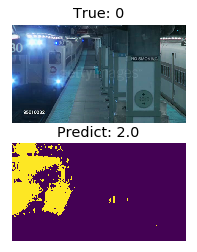

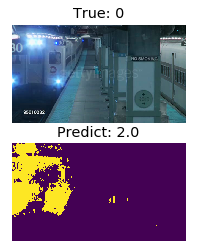

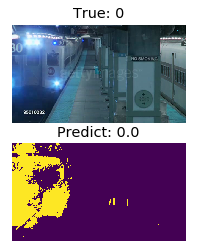

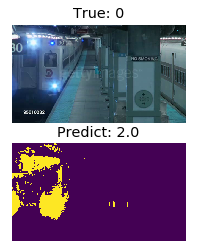

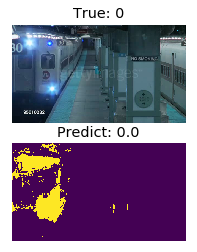

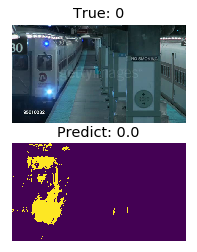

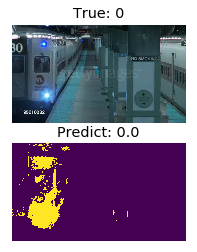

In [239]:
test_index = test_indexs[0]
labels = np.asarray(labels)
y_test = labels[test_index]
pred = preds[0]
for i,idx in enumerate(test_index):
    original = ori[idx]
    proc = processed[idx].reshape(SHAPE)
    title1 = "True: " + str(y_test[i])
    title2 = "Predict: " + str(pred[i])
    displayH(original, proc, title1, title2, path="/ex6_%s.png", frame_number=idx, save=True)

In [218]:
#KFold, shuffle true  
processed_data = np.asarray(processed)
from sklearn.model_selection import KFold
sk_scores = []
kf = KFold(n_splits=5, shuffle=True)
for train_index, test_index in kf.split(processed):
    X_train, y_train = processed_data[train_index], labels[train_index]
    X_test, y_test = processed_data[test_index], labels[test_index]
    Ein, Eout, pred = Logistic(X_train, X_test, y_train, y_test)
    sk_scores.append(Eout)
print("mean score:", np.mean(sk_scores))
print("std score:", np.std(sk_scores))
print("scores",sk_scores)

mean score: 0.9910101010101011
std score: 0.011011490969625573
scores [0.9777777777777777, 1.0, 0.9772727272727273, 1.0, 1.0]


In [ ]:
sample vs performance 
1) sample from whole day  
2) sample only from specific period of time 

Date: Feb 18 
Experiment 1: 
1) train bg subtraction with hist=500, shadow=true
2) generate fg, threshold < 240 
3) filter: morphological operations: closing, opening 
4) capacity counting: ratio between white(fg) and black(bg)

Result:
too much noise, due to the train is also considered as foreground object (undesirable result) 
and illumination (train light) 

Date: Feb 25 
Experiment 2:
1) train bg subtraction with hist=500, shadow=true
2) generate fg, GaussianBlur, threshold < 240 
3) filter: morphological operations: closing, opening 
4) capacity counting: ratio between white(fg) and black(bg)

Result:
No improvement. too much noise, due to the train is also considered as foreground object (undesirable result) 
and illumination (train light) 

Date: Feb 25 
Experiment 3: 
1) train bg subtraction with hist=500, shadow=true
2) generate fg, GaussianBlur, threshold < 240 
3) filter: morphological operations: closing, opening 
4) apply mask to filtered frames
5) capacity counting: ratio between white(fg) and black(bg)

Result:
Can remove train from region of interest(ROI). However, there are some noise from train light on ROI.
Accuracy: 0.71 

Next goals for improvement: 
detect best ROI
detect roughness (texture) in ROI 

Date: Feb 26 
Experiment 4: 
1) train bg subtraction with hist=100, shadow=true, learningRate=0.01
2) generate fg, GaussianBlur, threshold < 240 
3) filter: morphological operations: closing, opening 
4) apply mask to filtered frames
5) capacity counting: ratio between white(fg) and black(bg)

Result:
The noise due to the train's light decrease significantly in hardcoded ROI
due to the number of history image is reduced.
So, the bg keep changing dynamicly. 
However, accurary drops because the bg image changes, so it cant detect well on highly crowdedness. 
(AC: 0.42). 

Next goals for improvement: 
illumination invariant 
detect best ROI
detect roughness (texture) in ROI 
check labels

March 7
Experiment 4: 
1) train bg subtraction with hist=20, shadow=true, learningRate=0.01
2) generate fg, GaussianBlur, threshold < 240 
3) filter: morphological operations: closing, opening 
4) convert each processed img to 1d array
5) apply logistic regression: AC ~0.9864864864864865
6) pca(n=80) and LR Train accuracy 1.0 Test accuracy 0.972972972972973
6) pca(n=80) and SVM Train accuracy 1.0 Test accuracy 0.9594594594594594
7) confusion matrix, misclassify 1 image (True 2, pred 0)

need learnind curve by varying number of train_image for training background subtractor 

In [ ]:
pca 
- dimensionality reduction while keeping info as much as possible 
- visualization    
- noise reduction
the direction that has highest variance is signal
the direction that has low variance is maybe noise 
Why ? speed up training process, can handle more points
Choose n_components that preserve 90% of the information 
How to compare classifiers ? How to tune parameters? 